In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DOS SINAIS (APENAS VALORES REAIS) ---
np.random.seed(42)
n_samples = 4000
order = 5  # M=5 (6 coeficientes)

# Entrada: Ruído branco real
x = np.random.randn(n_samples)

# Planta Desconhecida (Sistema Real)
w_true = np.array([0.1, -0.5, 0.2, 0.4, -0.1, 0.05])
d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
# Adicionando ruído de medição
d = d_clean + 0.01 * np.random.randn(n_samples)

# --- 2. EXECUÇÃO DO POWER-OF-TWO ERROR LMS ---
# bd: word length (ex: 8 bits) define o limiar de erro pequeno
# tau: ganho para erros muito pequenos (abaixo de 2^(-bd+1))
# step_size (mu): passo de adaptação
filt_p2 = pdf.Power2ErrorLMS(
    filter_order=order,
    bd=8, 
    tau=0.001,
    step_size=0.01
)

result = filt_p2.optimize(x, d, verbose=True, return_internal_states=True)

[Power2ErrorLMS] Completed in 14.358 ms


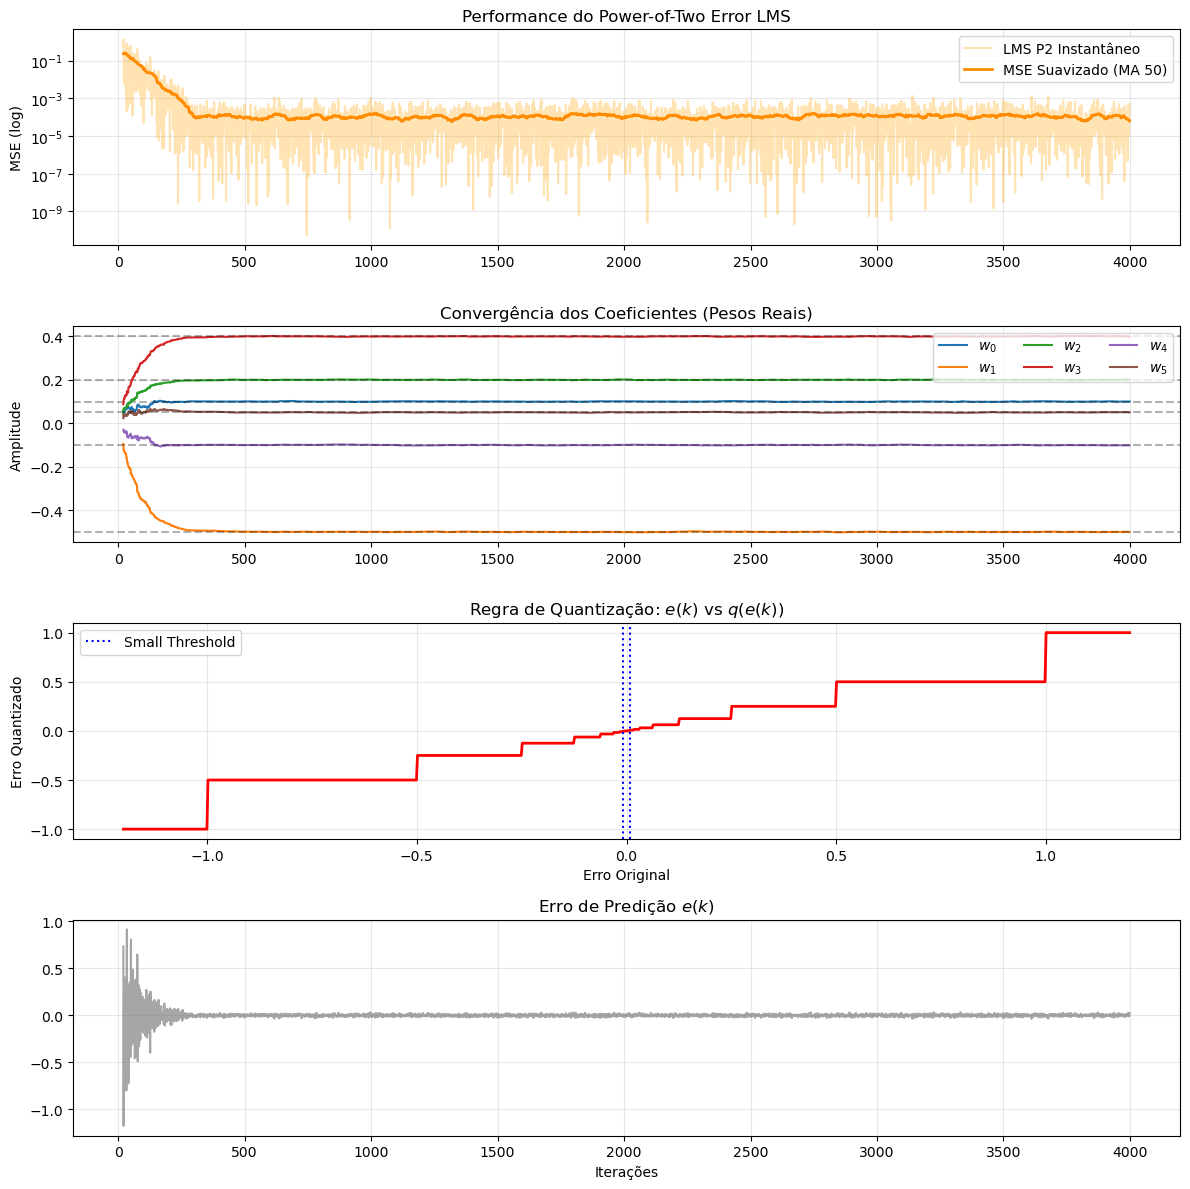

In [3]:
# --- 3. ANÁLISE VISUAL ---
offset = 20
mse = result.mse()
t = np.arange(len(mse))
# Alinhamento do histórico (removendo w_init do construtor)
coeffs_history = result.coefficients[1:]

plt.figure(figsize=(12, 12))

# Subplot 1: MSE (Curva de Aprendizado)
plt.subplot(4, 1, 1)
plt.semilogy(t[offset:], mse[offset:], label='LMS P2 Instantâneo', alpha=0.3, color='orange')
mse_smooth = np.convolve(mse, np.ones(50)/50, mode='same')
plt.semilogy(t[offset:], mse_smooth[offset:], label='MSE Suavizado (MA 50)', color='darkorange', lw=2)
plt.title('Performance do Power-of-Two Error LMS')
plt.ylabel('MSE (log)')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Subplot 2: Trajetória dos Coeficientes
plt.subplot(4, 1, 2)
for i in range(coeffs_history.shape[1]):
    plt.plot(t[offset:], coeffs_history[offset:, i], label=f'$w_{i}$')
    plt.axhline(y=w_true[i], color='black', linestyle='--', alpha=0.3)
plt.title('Convergência dos Coeficientes (Pesos Reais)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', ncol=3)

# Subplot 3: Visualização da Quantização (Erro vs Erro Quantizado)
# Vamos reconstruir a regra de quantização para visualização
plt.subplot(4, 1, 3)
e_test = np.linspace(-1.2, 1.2, 1000)
small_thr = result.extra["small_threshold"]
qe_test = []
for ek in e_test:
    ae = abs(ek)
    if ae >= 1.0: qe_test.append(np.sign(ek))
    elif ae < small_thr: qe_test.append(filt_p2.tau * np.sign(ek))
    else: qe_test.append((2.0 ** np.floor(np.log2(ae))) * np.sign(ek))

plt.plot(e_test, qe_test, color='red', lw=2)
plt.axvline(x=small_thr, color='blue', linestyle=':', label='Small Threshold')
plt.axvline(x=-small_thr, color='blue', linestyle=':')
plt.title('Regra de Quantização: $e(k)$ vs $q(e(k))$')
plt.xlabel('Erro Original')
plt.ylabel('Erro Quantizado')
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 4: Erro Residual
plt.subplot(4, 1, 4)
plt.plot(t[offset:], result.errors[offset:], color='gray', alpha=0.7)
plt.title('Erro de Predição $e(k)$')
plt.xlabel('Iterações')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()